In [ ]:
# IMPORTACIÓN DE LIBRERIAS
import pandas as pd
from scipy import stats as st
import math  as mt
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sbn

# LECTURA DE DATOS
visits = pd.read_csv('data/visits_log_us.csv')
orders = pd.read_csv('data/orders_log_us.csv')
costs  = pd.read_csv('data/costs_us.csv')

## Inspección Inicial de Datos

In [ ]:
print(visits.info())
display(visits.head(2)) 
print(orders.info())
display(orders.head(2))
print(costs.info())
display(costs.head(2))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Device     359400 non-null  object
 1   End Ts     359400 non-null  object
 2   Source Id  359400 non-null  int64 
 3   Start Ts   359400 non-null  object
 4   Uid        359400 non-null  uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB
None


,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740


### Limpieza y corrección de datos

Para el DF **visits**:
- Estandarizar los nombres de las columnas a minúsculas y sin espacios.
- Cambiar el tipo de datos *end_ts* y *start_ts* a date.
  
Para el DF **orders**:
- Estandarizar los nombres de las columnas a minúsculas y sin espacios.
- Cambiar el tipo de datos *buy_ts* a date.
  
Para el DF **costs**:
- Cambiar el tipo de dato de la columna *dt* a date.

In [ ]:
def clean_colnames(df):
    df.columns = df.columns.str.lower().str.replace(' ','_')
    return df

def convert_dtypes(df, col, format):
    df[col] = pd.to_datetime(df[col], format = format)
    return df

# CORRECCIÓN DE NOMBRES DE COLUMNAS
visits.columns = clean_colnames(visits).columns
costs.columns = clean_colnames(costs).columns
orders.columns = clean_colnames(orders).columns
# CORRECCIÓN DE TIPOS DE DATOS
visits['end_ts'] = convert_dtypes(visits, 'end_ts', '%Y-%m-%d %H:%M:%S')['end_ts']
visits['start_ts'] = convert_dtypes(visits, 'start_ts', '%Y-%m-%d %H:%M:%S')['start_ts']
orders['buy_ts'] = convert_dtypes(orders, 'buy_ts', '%Y-%m-%d %H:%M:%S')['buy_ts']
costs['dt'] = convert_dtypes(costs, 'dt', '%Y-%m-%d')['dt']

## Paso 2. Métricas

Procedemos a extraer la semana y mes para los DF **visits**, **orders** y **cost** para determinar los requerimientos de los pasos **2.1-2.3**.

### Visitas

In [5]:
# TRATAMIENTO DE FECHAS (mes y semana) PARA visits
visits['start_year'] = visits['start_ts'].dt.isocalendar().year
visits['start_month'] = visits['start_ts'].dt.month
visits['start_week'] = visits['start_ts'].dt.isocalendar().week
visits['start_day'] = visits['start_ts'].dt.date
#display(visits.sample(3))

### Análisis de Adherencia y Volumen: DAU, WAU y MAU

In [5]:
### DAU, WAU, MAU
dau_total = visits.groupby('start_day').agg({'uid': 'nunique'}).mean()
wau_total = visits.groupby(['start_year', 'start_week']).agg({'uid': 'nunique'}).mean()
mau_total = visits.groupby(['start_year', 'start_month']).agg({'uid': 'nunique'}).mean()
print(f"Usuarios promedio por: día - {int(dau_total)}, semana - {int(wau_total)}, mes - {int(mau_total)}.")

NameError: name 'visits' is not defined

### Frecuencia de Uso: Sesiones Promedio Diarias

In [ ]:

daily_sessions = visits.groupby('start_day').agg({'uid': 'count'}).mean()
print(f"Sesiones promedio por: {int(daily_sessions)}")

Sesiones promedio por: 987


### Análisis de la Duración de la Sesión (AAS)

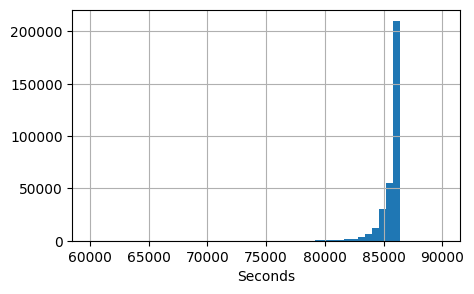

In [ ]:

visits['session_duration_sec'] = (visits['start_ts'] - visits['end_ts']).dt.seconds
non_zero_visits = visits.query("session_duration_sec > 0")['session_duration_sec']
plt.figure(figsize=(5, 3))
non_zero_visits.hist(bins=50, range =(60000,90000))
plt.xlabel('Seconds')
plt.show()

Del gráfico anterior podemos ver que la distribución no es normal, por lo que para indicar la duración de las sesiónes se utlizará la *moda* de los datos.

In [9]:
sess_dur = non_zero_visits.mode()
print(f"Duración por sesión en segundos: {int(sess_dur)} s")

Duración por sesión en segundos: 86340 s


### Comportamiento del Usuario: Cálculo del Factor de Adherencia

El factor de adherencia se determinará usando la formula:

$\mathrm{sticky-factor} = \frac{\mathrm{DAU}}{\mathrm{WAU}}$

In [10]:
stck_fac = dau_total/wau_total
print(f"El factor de adherencia es: {float(stck_fac.round(2))}")

El factor de adherencia es: 0.16


### Análisis de Cohortes: Preparación de Datos de Compras

In [9]:
# CREACIÓN DE LA COLUMNA 'buy_day'
orders['buy_day'] = orders['buy_ts'].astype('datetime64[D]')
first_buy = orders.groupby('uid')['buy_day'].min()
first_buy.name = 'first_buy'
orders = orders.join(first_buy, on ='uid')
display(orders[:1])

,buy_ts,revenue,uid,buy_day,first_buy
0,2017-06-01 00:10:00,17.0,10329302124590727494,2017-06-01,2017-06-01


In [10]:
# DETERMINAR EL DÍA DE LA PRIMER VISITA
first_visit = visits.groupby('uid')['start_ts'].min().astype('datetime64[D]')
first_visit.name = 'first_visit_date'
# ELIMINACIÓN DE COLUMNAS INNECESARIAS 
clean_visits = visits.drop(['start_year','start_month','start_week',
                           'start_day','session_duration_sec','end_ts'],axis =1)
clean_visits = clean_visits.join(first_visit, on ='uid') 
display(clean_visits[:1])

,device,source_id,start_ts,uid,first_visit_date
0,touch,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20


In [11]:
# SE HACE UNA FUSIÓN ENTRE LAS ORDENES Y LAS VISITAS
orders_visits = orders.merge(clean_visits, on = 'uid')
#orders_visits['day_until_buy'] = orders_visits['first_buy'] - orders_visits['first_visit_date']
orders_visits.drop(['buy_ts','start_ts'],axis=1,inplace=True)
# SE DETERMINAN LAS SEMANAS PARA LA PRIMER COMPRA, VISITA Y COMPRAS SUBSECUENTES
orders_visits['buy_week'] = pd.to_datetime(orders_visits['buy_day'], unit='d'
) - pd.to_timedelta(orders_visits['buy_day'].dt.dayofweek, unit='d')
orders_visits['first_buy_week'] = pd.to_datetime(orders_visits['first_buy'], unit='d'
) - pd.to_timedelta(orders_visits['first_buy'].dt.dayofweek, unit='d')
orders_visits['first_visit_week'] = pd.to_datetime(orders_visits['first_visit_date'], unit='d'
) - pd.to_timedelta(orders_visits['first_visit_date'].dt.dayofweek, unit='d')
# CREACIÓN DE LAS EDADES DE LAS COHORTES
orders_visits['cohort_lifetime'] = ((
    orders_visits['first_buy_week'] - orders_visits['first_visit_week']
)/ np.timedelta64(1, 'W')).round().astype(int)
#display(orders_visits.sample(3))

### Visualización de Conversión de Cohortes (Semanales):

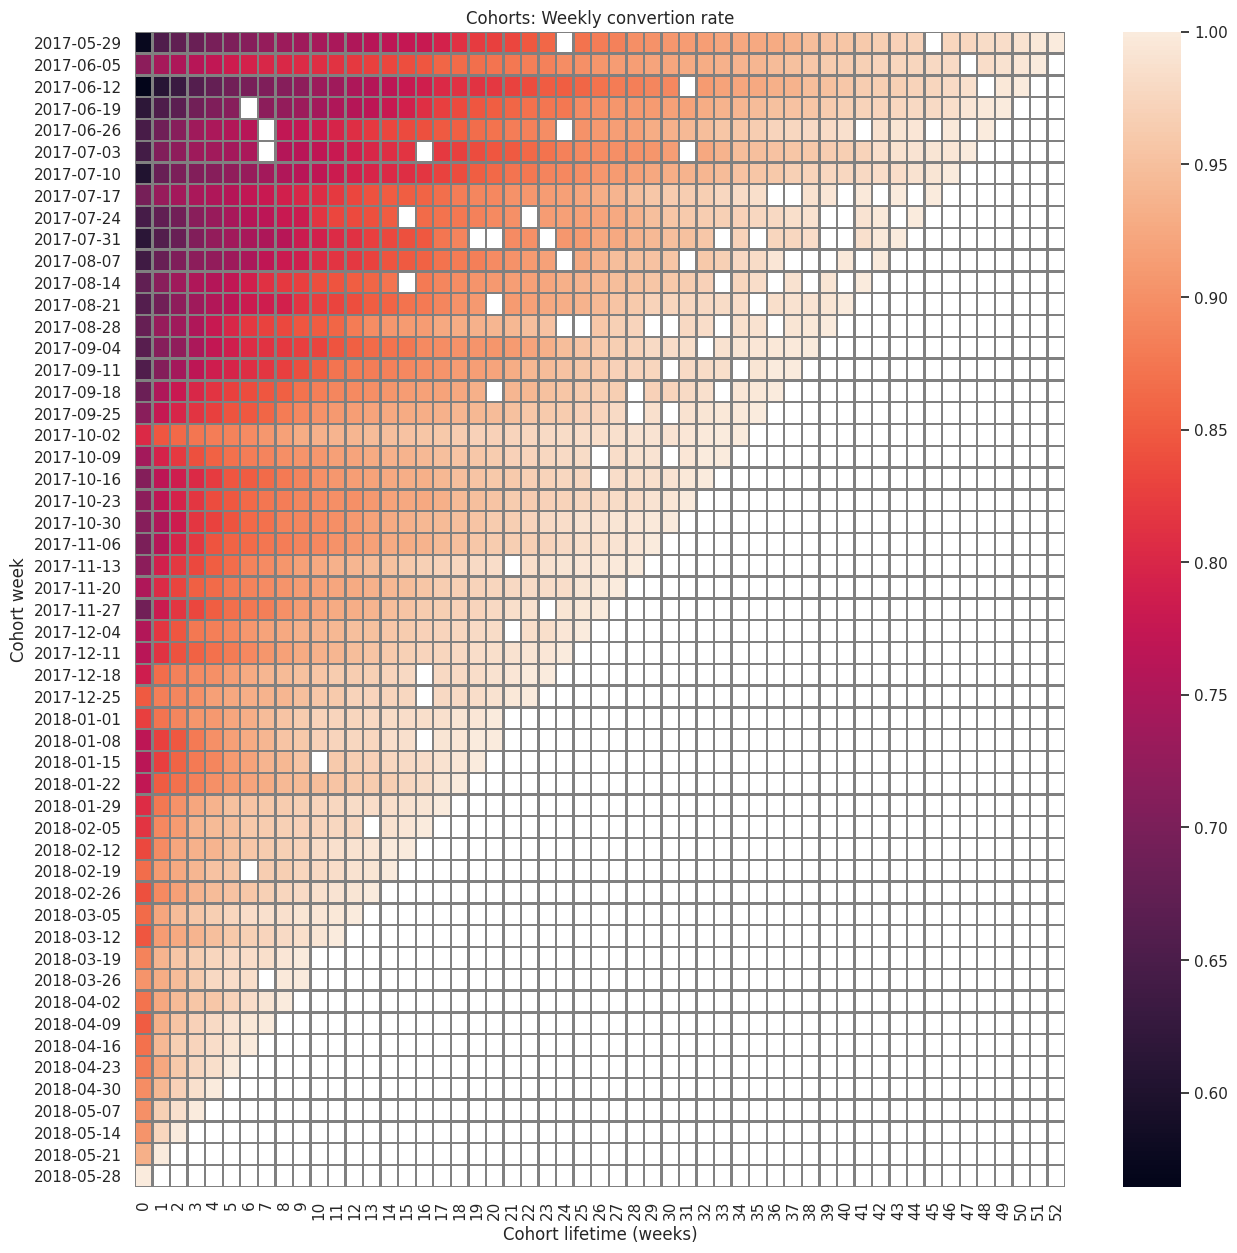

In [12]:
cohorts = orders_visits.groupby(['first_visit_week', 
                                 'cohort_lifetime']).agg({'uid': 'nunique'}).reset_index()
cohorts.rename(columns={'uid':'n_user'}, inplace=True)
init_user_count = cohorts.groupby('first_visit_week')['n_user'].sum().reset_index()
init_user_count.rename(columns={'n_user':'total_user'}, inplace=True)
cohorts = cohorts.merge(init_user_count, on = 'first_visit_week')
cohorts['convertion'] = cohorts['n_user']/cohorts['total_user']
cohorts['convertion_sum'] = cohorts.groupby(['first_visit_week'])['convertion'].cumsum()
cohorts['first_visit_week'] = cohorts['first_visit_week'].dt.strftime('%Y-%m-%d')
#display(cohorts.tail())
convertion = cohorts.pivot_table(index='first_visit_week', columns = 'cohort_lifetime', 
                                values = 'convertion_sum')
# MAPA DE CALOR PARA LAS TASAS DE CONVERSIÓN POR COHORTES SEMANALES
sbn.set(style='white')
plt.figure(figsize=(15, 15))
plt.title('Cohorts: Weekly convertion rate')
sbn.heatmap(convertion, annot=False, fmt='.1%', linewidths=1, linecolor='gray')
plt.xlabel('Cohort lifetime (weeks)')
plt.ylabel('Cohort week')
plt.show()

Del grafico anterior podemos ver que para las cohortes de antes del **27-11-2017** existia una conversión de aproximadamente $60\%$ durante la primer semana. Estás tasas de conversión comienzan a mejorar conforme nuevas cohortes nacen, por ejemplo, las cohortes depues del **16-04-2018** alcanzan una tasa de conversión de entre $80-90\%$ durante la primer semana.

In [13]:
orders_visits['cohort_lifetime_buy'] = ((
    orders_visits['buy_week'] - orders_visits['first_buy_week']
)/ np.timedelta64(1, 'W')).round().astype(int)

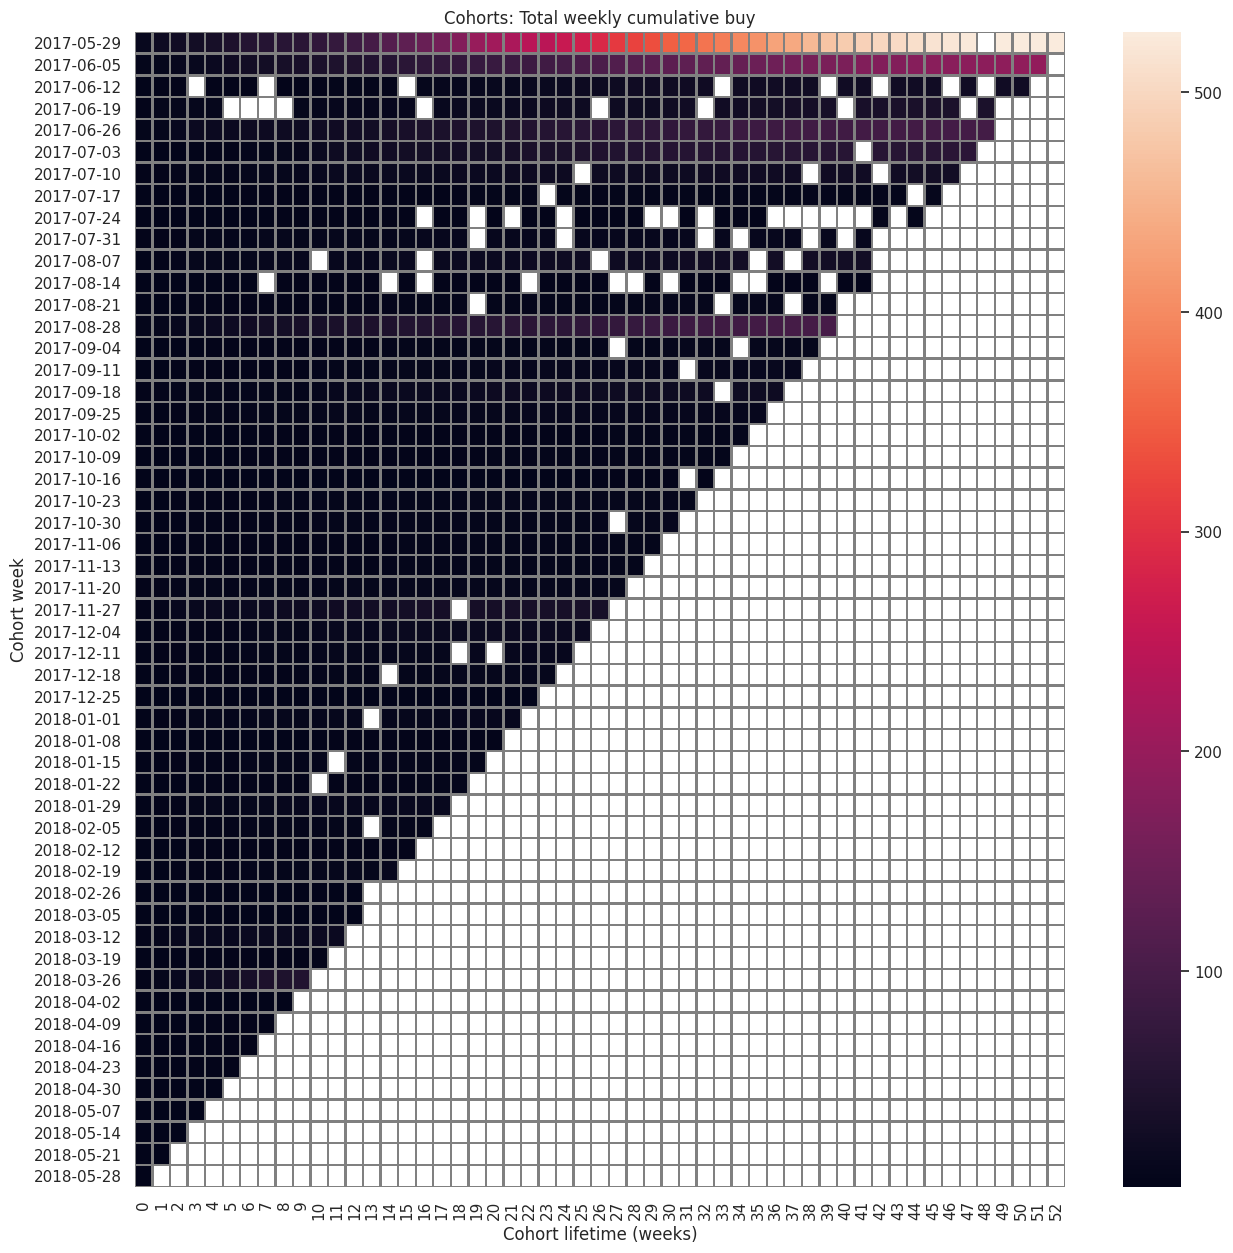

In [ ]:
cohorts_buy = orders_visits.groupby(['first_buy_week','cohort_lifetime_buy']).agg({'uid':'count'}).reset_index()
cohorts_buy.rename(columns={'uid':'total_buy'}, inplace=True)
n_users = orders_visits.groupby('first_buy_week')['uid'].nunique().reset_index()
n_users.rename(columns={'uid':'total_users'}, inplace=True)
cohorts_buy = cohorts_buy.merge(n_users, on  = 'first_buy_week')
#display(n_users.head())
cohorts_buy['mean_buy'] = cohorts_buy['total_buy']/cohorts_buy['total_users']
cohorts_buy['total_mean_buy'] = cohorts_buy.groupby('first_buy_week')['mean_buy'].cumsum()
cohorts_buy['first_buy_week'] = cohorts_buy['first_buy_week'].dt.strftime('%Y-%m-%d')
cum_buy = cohorts_buy.pivot_table(index='first_buy_week',columns = 'cohort_lifetime_buy',
                                 values = 'total_mean_buy')
#display(cohorts_buy.sample(5))
# MAPA DE CALOR PARA LAS SUMA ACUMULADA DE COMPRAS POR COHORTE SEMANAL
sbn.set(style='white')
plt.figure(figsize=(15, 15))
plt.title('Cohorts: Cumulative Mean Buy per User')
sbn.heatmap(cum_buy, annot=False, fmt='.1%', linewidths=1, linecolor='gray')
plt.xlabel('Cohort lifetime (weeks)')
plt.ylabel('Cohort week')
plt.show()

Del gráfico anterior podemos ver que solo la primera cohorte alcanzó las 500 ventas en un año de vida. Todas las cohortes posteriores alcanzaron solo un número reducido de compras (menos de 300). La tendencia general parece ser que cada usuario compra cada vez menos (en promedio).

### Ingreso Promedio por Usuario (ARPU) por Cohorte:

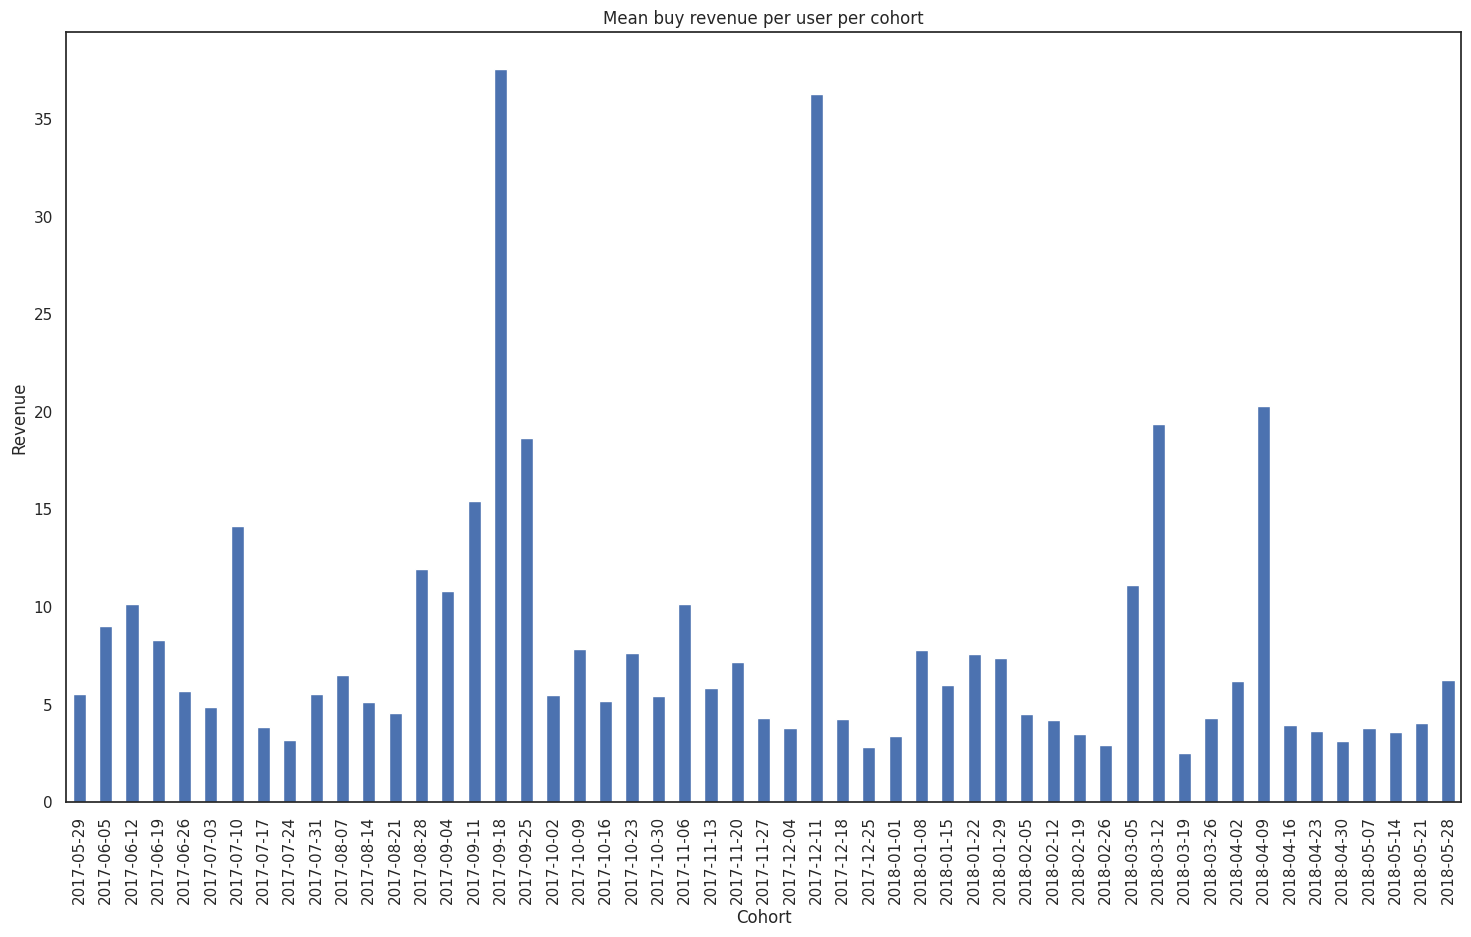

In [15]:
# CALCULO DE GANANCIAS POR COHORTE POR USUARIO
cohort_revenue = orders_visits.groupby(['first_buy_week',
                                        'cohort_lifetime_buy']).agg({'revenue':'sum',
                                                                    'uid':'count'}).reset_index()
cohort_revenue['mean_rev_p_user'] = cohort_revenue['revenue']/cohort_revenue['uid']
mean_rev_per_cohort = cohort_revenue.groupby('first_buy_week').agg({'mean_rev_p_user':'mean'}).reset_index()
mean_rev_per_cohort['first_buy_week'] = mean_rev_per_cohort['first_buy_week'].dt.strftime('%Y-%m-%d')

# GRÁFICO DE BARRAS PARA EL TAMAÑO PROMEDIO DE VENTA POR USUARIO POR COHORTE
mean_rev_per_cohort.plot(x='first_buy_week', y='mean_rev_p_user',
        kind = 'bar', title = 'Mean buy revenue per user per cohort',
        xlabel ='Cohort', ylabel = 'Revenue', legend = False,figsize=(18, 10))
plt.show()
#display(mean_rev_per_cohort)

Del gráfico anterior podemos observar que no parece haber un patrón obvio en el tamaño de compra promedio por usuario de cada cohorte.

### Cálculo del LTV (Lifetime Value) a 12 meses:

In [16]:
revenue =  orders_visits.groupby(['first_buy_week','cohort_lifetime_buy']
                                ).agg({'revenue':'sum'}).reset_index()
n_users = orders_visits.groupby('first_buy_week')['uid'].nunique().reset_index()
revenue = revenue.merge(n_users, on = 'first_buy_week')
revenue['ltv'] = revenue['revenue']/revenue['uid']
revenue.rename(columns = {'cohort_lifetime_buy':'age','uid':'n_buyers'}, inplace=True)
result = revenue.pivot_table(index='first_buy_week', columns='age',values='ltv').round(4)
LTV_12 = result.cumsum(axis=1).mean(axis=0)[52]
print(f"El LTV promedio para un año es de: {LTV_12.round(2)}")
#display(result.fillna(''))

El LTV promedio para un año es de: 2878.38


### Análisis de Costos de Marketing (Total y por Canal):

El gasto total en marketing asciende a 329131.62.


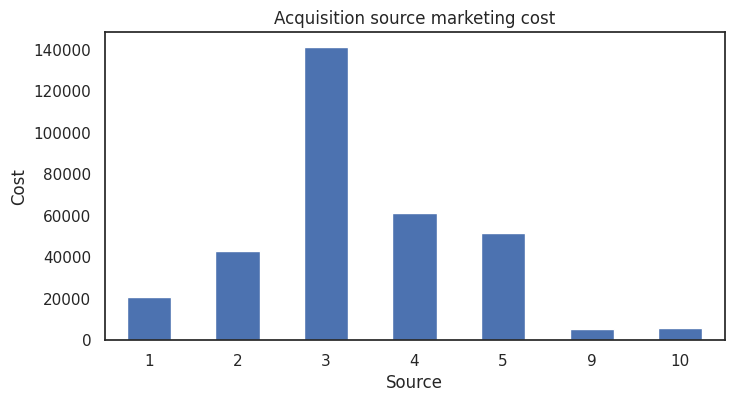

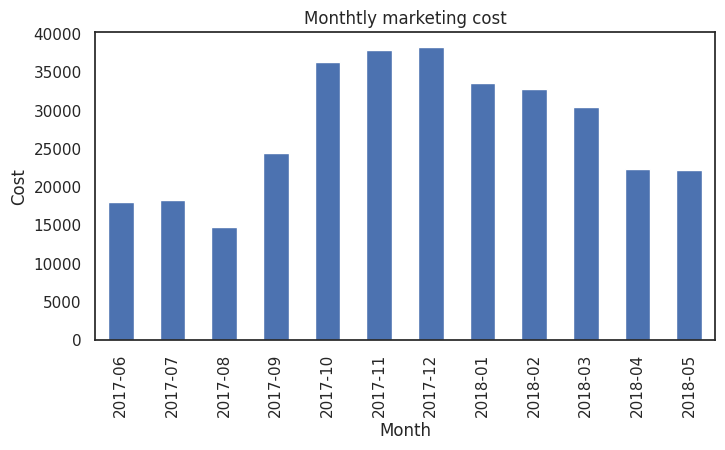

In [17]:
costs['dt_month'] = costs['dt'].astype('datetime64[M]')
#display(costs)
# COSTOS TOTALES
mkt_total = costs['costs'].sum()
# COSTOS POR CANAL DE ADQUISICIÓN
mkt_adq = costs.groupby("source_id").agg({'costs':'sum'}).reset_index()
# COSTOS MENSUALES
mkt_month = costs.groupby("dt_month").agg({'costs':'sum'}).reset_index()
mkt_month['dt_month'] = mkt_month['dt_month'].dt.strftime('%Y-%m')
print(f"El gasto total en marketing asciende a {mkt_total}.")
# GRÁFICO DE BARRAR PARA EL COSTO POR CANALES DE ADQUISICIÓN 
mkt_adq.plot(x='source_id', y='costs',
        kind = 'bar', title = 'Acquisition source marketing cost',
        xlabel ='Source', ylabel = 'Cost', legend = False, figsize=(8, 4), rot = 0)
# GRÁFICO DE BARRAS PARA EL COSTO MENSUAL
mkt_month.plot(x='dt_month', y='costs',
        kind = 'bar', title = 'Monthtly marketing cost',
        xlabel ='Month', ylabel = 'Cost', legend = False, figsize=(8, 4))
plt.show()

Del gráfico anterior vemos claramente que el mayor presupuesto de marketing se destinó a la fuente 3. El mayor gasto en marketing se realizó entre los meses de Octubre a Diciembre del 2017 coincidiendo con el fin de año y proximo a la navidad.

In [22]:
orders['first_buy_month'] = orders['first_buy'].astype('datetime64[M]')
orders['buy_month'] = orders['buy_ts'].astype('datetime64[M]')
orders_ = orders[['revenue','uid','first_buy_month','buy_month']]
orders_ = orders_.merge(visits[['source_id','uid']],on='uid')
# CREACIÓN DE LAS COHORTES MENSUALES
cohort = orders_.groupby(['first_buy_month','buy_month','source_id']).agg({'revenue':'sum'}).reset_index()

mkt_month_source =  costs.groupby(['dt','source_id']).agg({'costs':'sum'}).reset_index()
mkt_month_source.rename(columns = {'dt':'buy_month'}, inplace=True)

# CALCULO DEL TAMAÑO DE CADA COHORTE
cohort_size = orders_.groupby(['first_buy_month','source_id']).agg({'uid':'nunique'}).reset_index()
cohort_size.rename(columns = {'uid':'n_users'},inplace=True)

results = cohort.merge(cohort_size, on =['first_buy_month','source_id'])
results = results.merge(mkt_month_source, on = ['buy_month','source_id'])
results['age'] = ((results['buy_month'] - results['first_buy_month']
) / np.timedelta64(1, 'M')).round().astype('int')

# CALCULO DEL LTV, CAC Y ROMI
results['ltv'] = results['revenue']/results['n_users']
results['cac'] = results['costs']/results['n_users']
results['romi'] = results['ltv']/results['cac']

### ESTA FUNCIÓN PERMITE CALCULAR EL CAC, LTV Y ROMI POR FUENTE DE ADQUISICIÓN POR AÑO
def clr_source(df):
    s_id = df['source_id'].unique()
    source = []
    CAC = []
    LTV = []
    ROMI = []
    for s in s_id:
        res = df.query('source_id == @s')
        output = res.pivot_table(index='first_buy_month', columns='age',values='cac').round(4)
        CAC_12 = output.cumsum(axis=1).mean(axis=0)[11]
        output = res.pivot_table(index='first_buy_month', columns='age',values='ltv').round(4)
        LTV_12 = output.cumsum(axis=1).mean(axis=0)[11]
        source.append(s)
        CAC.append(CAC_12)
        LTV.append(LTV_12)
    res = pd.DataFrame({'source':source,'cac':CAC,'ltv':LTV})
    res['romi'] = res['ltv']/res['cac']
    return res
        
cac_ltv_romi = clr_source(results).round(2)
#display(cac_ltv_romi)

### Rentabilidad por Canal: CAC, LTV y ROMI Anual

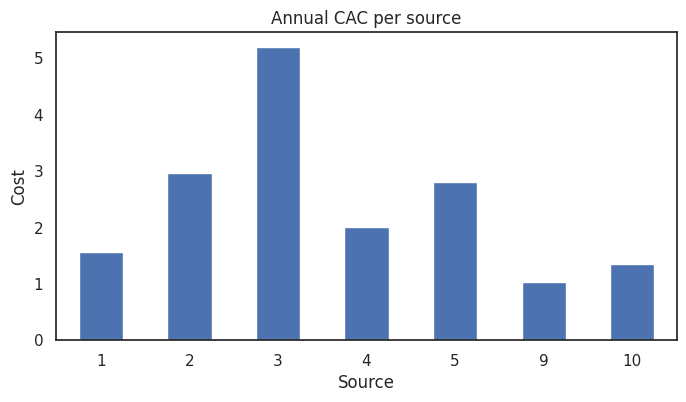

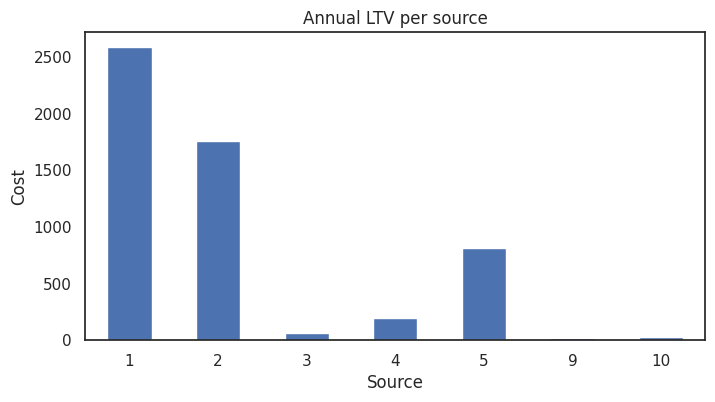

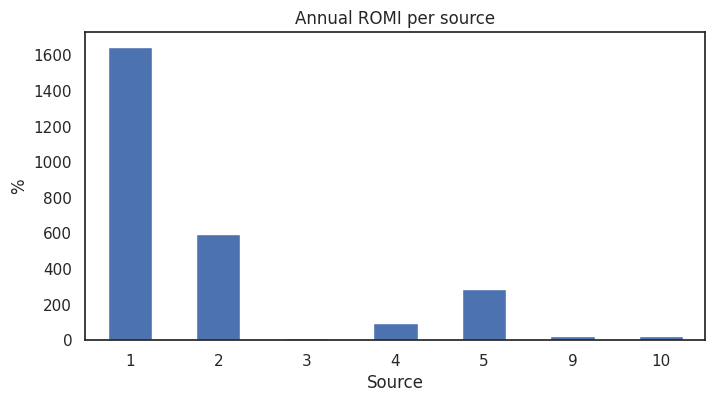

In [ ]:
# GRAFICOS DE CAC, LTV Y ROMI MENSUALES
cac_ltv_romi.plot(x='source', y='cac',
        kind = 'bar', title = 'Annual CAC per source',
        xlabel ='Source', ylabel = 'Cost', legend = False, figsize=(8, 4), rot = 0)
cac_ltv_romi.plot(x='source', y='ltv',
        kind = 'bar', title = 'Annual LTV per source',
        xlabel ='Source', ylabel = 'Cost', legend = False, figsize=(8, 4), rot = 0)
cac_ltv_romi.plot(x='source', y='romi',
        kind = 'bar', title = 'Annual ROMI per source',
        xlabel ='Source', ylabel = 'ROMI Value', legend = False, figsize=(8, 4), rot = 0)
plt.show()

Del gráfico anterior puede verse que las fuentes más rentables son la **1** y **2**.

# Conclusiones

Del análisis exploratorio anterior, puede concluirse que las dos mejores fuentes de aquisición en las que enfocarse son **1** y **2**. Sus ROMIs son sumamente rentables anualmente. Se recomienda reducir el soporte para las fuentes **3**, **9** y **10**. Las tasas promedio de conversión parecen bastante estables y adecuadas para las cohortes más nuevas. No se recomienda tomar acción.